# Blackjack game with Q-Learning

## Blackjack game

The goal of the game is to beat the dealer by having a hand value of 21 or closest to 21 without going over. Each player is dealt two cards, and then has the option to "hit" and receive additional cards to improve their hand. They can also choose to “stand” and keep the cards they have. If the player exceeds 21, they “bust” and automatically lose the round. If the player has exactly 21, they automatically win. Otherwise, the player wins if they are closer to 21 than the dealer. \
The value of each card is listed below:
- 10/Jack/Queen/King → 10
- 2 through 9 → Same value as card
- Ace → 1 or 11 (Player’s choice)

The game starts with players making their bets, after which the dealer will deal two cards to each player and two to himself, with one card face up and one face down (known as the "hole" card). Players then make their decisions to hit or stand. Once all players have completed their turns, the dealer will reveal their hole card and hit or stand according to a set of rules. If the dealer busts (goes over 21), players who have not bust win. If neither the player nor dealer busts, the hand closest to 21 wins.


In [17]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
import enum
import sys
import random
import numpy as np

from collections import defaultdict
import seaborn as sns
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

## Setting up the basics of the game

### Card and deck

The cards' definitions are set up below. 
- `ranks`: a dictionary that maps the string representations of card ranks to their numerical values
- `Suit`: an enumeration of the four suits in a standard deck of playing cards
- `Card`: a class that represents an individual card and contains properties such as the card's suit, rank, and value
- `Deck`: a class that represents a deck of cards and contains methods for shuffling the deck, dealing cards, peeking at the top card, adding cards to the bottom of the deck, and printing the deck

The `Deck` class initializes an empty list of cards when created and populates it with `num` standard decks of playing cards. The `shuffle` method randomly shuffles the cards in the deck. The `deal` method returns the top card of the deck, and the `peek` method returns the top card without removing it from the deck. The add_to_bottom method adds a card to the bottom of the deck, and the `__str__` method returns a string representation of the deck. The `__len__` method returns the number of cards in the deck.

In [18]:
numbers = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}

class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"
    
class Card:
    def __init__(self, suit, number, value):
        self.suit = suit
        self.number = number
        self.value = value
        
    def __str__(self):
        return self.number + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for number, value in numbers.items():
                    self.cards.append(Card(suit, number, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

### Setting up the game's rules

The evaluation of the dealer's hand is done here, following a proper set of rules that are predictable. As the game goes, the dealer will be following *Hard 17* rule. This means the dealer will not hit again if the Ace yields a 17. This also means that Aces initially declared as 11's can be changed to 1's as new cards come.

In [19]:
def dealer_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.number == "ace":
            num_ace += 1
            use_one += card.value[0] # It will be using Ace is equal to 1 in here
        else:
            use_one += card.value
    
    if num_ace > 0:
        ace_counter = 0
        while ace_counter < num_ace:
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 17 and use_eleven <= 21:
                return use_eleven
            else:
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

As for the evaluation of the player's hand, it focus on the value of Ace. For instance, if the Ace obtained gets the player to the total sum of 18 to 21, then Ace is equal to 11, otherwise it is equal to 1.

In [20]:
def player_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.number == "ace":
            num_ace += 1
            use_one += card.value[0] # It will be using Ace is equal to 1 in here
        else:
            use_one += card.value
    
    if num_ace > 0:
        ace_counter = 0
        while ace_counter < num_ace:
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 18 and use_eleven <= 21:
                return use_eleven
            else:
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

Below, the code for the logic in which the dealer will follow is presented. As the action is rather straightforward, nothing much happens. Following the Hard 17 rule, the dealer will stop hitting after the total is 17 or more.

In [21]:
def dealer_turn(dealer_hand, deck):
    dealer_value = dealer_eval(dealer_hand)
    while dealer_value < 17:
        dealer_hand.append(deck.deal()) # Making the Hit
        dealer_value = dealer_eval(dealer_hand)

    return dealer_value, dealer_hand, deck

## Setting up the OpenAI environment for Blackjack

The solution is to create a custom class in order to train the bot.

The class has two main attributes:
- the `action_space` attribute, which is a 2-element discrete space representing the two possible actions the player can take: hit (0) or stand (1)
- the `observation_space` attribute, which is a tuple representing the state of the game, consisting of two elements: player hand value (18 possible values ranging from 3 to 20) and the dealer's upcard value (10 possible values ranging from 2 to 11).

The class also implements four main methods:

- `step(action)` method, which takes the player's action as an input, updates the game state, calculates the reward, and returns the new state and the reward.
- `reset()` method, which resets the game to its initial state and returns the start state.
- `_take_action(action)` method, which updates the player's hand according to the player's action.
- `dealer_turn(dealer_hand, bj_deck)` method, which calculates the dealer's final hand value according to the dealer's rules.

The game starts with an initial balance of 1000, and a deck of cards made up of 6 decks. The deck is initialized using the `Deck` class. The game can end in three ways: the player stands, the player's hand value exceeds 21, or the dealer's hand value exceeds 21. The rewards are -1 for losing, 0 for tie, and 1 for winning.

In [22]:
INITIAL_BALANCE = 1000
NUM_DECKS = 6

class BlackjackEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(BlackjackEnv, self).__init__()
        
        # Initialize the blackjack deck.
        self.bj_deck = Deck(NUM_DECKS)
        
        self.player_hand = []
        self.dealer_hand = []
        
        self.reward_options = {"lose":-1, "tie":0, "win":1}
        
        # hit = 0, stand = 1
        self.action_space = spaces.Discrete(2)
        
        # Second element of the tuple is the range of possible values for the dealer's upcard. (2 through 11)
        self.observation_space = spaces.Tuple((spaces.Discrete(18), spaces.Discrete(10)))
        
        self.done = False
        
    def _take_action(self, action):
        if action == 0: # hit
            self.player_hand.append(self.bj_deck.deal())
            
        # re-calculate the value of the player's hand after any changes to the hand.
        self.player_value = player_eval(self.player_hand)
    
    def step(self, action):
        self._take_action(action)
        
        # End the episode/game is the player stands or has a hand value >= 21.
        self.done = action == 1 or self.player_value >= 21
        
        # rewards are 0 when the player hits and is still below 21, and they keep playing.
        rewards = 0
        
        if self.done:
            # CALCULATE REWARDS
            if self.player_value > 21: # above 21, player loses automatically.
                rewards = self.reward_options["lose"]
            elif self.player_value == 21: # blackjack! Player wins automatically.
                rewards = self.reward_options["win"]
            else:
                ## Begin dealer turn phase.

                dealer_value, self.dealer_hand, self.bj_deck = dealer_turn(self.dealer_hand, self.bj_deck)

                ## End of dealer turn phase

                #------------------------------------------------------------#

                ## Final Compare

                if dealer_value > 21: # dealer above 21, player wins automatically
                    rewards = self.reward_options["win"]
                elif dealer_value == 21: # dealer has blackjack, player loses automatically
                    rewards = self.reward_options["lose"]
                else: # dealer and player have values less than 21.
                    if self.player_value > dealer_value: # player closer to 21, player wins.
                        rewards = self.reward_options["win"]
                    elif self.player_value < dealer_value: # dealer closer to 21, dealer wins.
                        rewards = self.reward_options["lose"]
                    else:
                        rewards = self.reward_options["tie"]
        
        self.balance += rewards
        
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 3 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
        
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        
        return obs, rewards, self.done, {}
    
    def reset(self): # resets game to an initial state
        # Add the player and dealer cards back into the deck.
        self.bj_deck.cards += self.player_hand + self.dealer_hand

        # Shuffle before beginning. Only shuffle once before the start of each game.
        self.bj_deck.shuffle()
         
        self.balance = INITIAL_BALANCE
        
        self.done = False
        
        # returns the start state for the agent
        # deal 2 cards to the agent and the dealer
        self.player_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_upcard = self.dealer_hand[0]
        
        # calculate the value of the agent's hand
        self.player_value = player_eval(self.player_hand)
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 2 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
            
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        
        return obs
    
    def render(self, mode='human', close=False):
        # convert the player hand into a format that is
        # easy to read and understand.
        hand_list = []
        for card in self.player_hand:
            hand_list.append(card.number)
            
        # re-calculate the value of the dealer upcard.
        upcard_value = dealer_eval([self.dealer_upcard])
        
        print(f'Balance: {self.balance}')
        print(f'Player Hand: {hand_list}')
        print(f'Player Value: {self.player_value}')
        print(f'Dealer Upcard: {upcard_value}')
        print(f'Done: {self.done}')
        
        print()

After the environment for Blackjack is created, it is necessary to create the Agent, or bot, that will learn how to play the game.

With the learning method of choice defined as the **Q-Learning**, a class `Agent` represents a reinforcement learning agent that can learn from its environment through trial and error. The agent has various attributes such as the environment it interacts with, its exploration factor `epsilon`, learning rate `alpha`, discount factor `gamma`, and the number of episodes it needs to train on `num_episodes_to_train`. The `Agent` class has several methods that allow it to learn from its interactions with the environment:
- `train` method: This method updates the exploration factor epsilon and the learning rate alpha after each action the agent takes. The epsilon decreases over time and the agent becomes less explorative as it trains, so that it takes more exploitation-based decisions in the future.

- `get_q_value` method: If the agent encounters a new observation, it sets the initial values of the Q-values for each action to 0.0. The Q-values represent the expected long-term reward of taking a specific action in a specific observation.

- `get_max_q_value` method: Given an observation, this method returns the maximum Q-value of all the actions that the agent can take.

- `choose_action` method: Based on the current observation, the agent uses this method to choose an action to take. If a random number is greater than the exploration factor epsilon, the agent chooses the action with the highest Q-value. Otherwise, it takes a random action.

- `learn` method: This method updates the Q-value of the action the agent took based on the reward it received and the utility of the next observation. The new Q-value is computed using a formula that combines the current Q-value with the reward and the discounted utility of the next observation.

Devo modificare questo e il markdown!!!! Spingiamo al top

In [23]:
class QLearningAgent():
    def __init__(self, env, gamma=0.99, alpha=0.5, epsilon=0.1, num_episodes=30000):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.num_episodes = num_episodes
        self.valid_actions = list(range(self.env.action_space.n))
        self.episodes_left = num_episodes
        # self.Q_table = dict()
        self.Q_table = defaultdict(lambda: defaultdict(float))


    # def get_q_value(self, observation, action):
      #   return self.Q_table.get((observation, action), 0.0)

    def choose_action(self, observation):
        if random.random() > self.epsilon:
            """
            q_values = {action: self.get_q_value(observation, action) for action in self.valid_actions}
            max_q_value = max(q_values.values())
            actions_with_max_q_value = [action for action, q_value in q_values.items() if q_value == max_q_value]
            action = random.choice(actions_with_max_q_value)
            """
            action = max(self.valid_actions, key=lambda a: self.Q_table[observation][a])
        else:
            action = random.choice(self.valid_actions)
        return action

    def learn(self, observation, action, reward, next_observation):
        """
        max_next_value = self.get_max_q_value(next_observation)
        temp_diff = self.gamma * max_next_value - self.get_q_value(observation, action)
        self.Q_table[(observation, action)] = self.get_q_value(observation, action) + self.alpha * (reward + temp_diff)
        """
        max_next_value = max(self.Q_table[next_observation].values(), default=0)
        self.Q_table[observation][action] += self.alpha * (reward + self.gamma * max_next_value - self.Q_table[observation][action])

    """def get_max_q_value(self, observation):
        q_values = [self.get_q_value(observation, action) for action in self.valid_actions]
        return max(q_values) if q_values else 0
    """

    def train(self):
        self.epsilon = self.epsilon * 0.99 if self.episodes_left > 0 else 0
        self.alpha = self.alpha if self.episodes_left > 0 else 0
        self.episodes_left -= 1

    def moving_average(self, lst, window = 100):
        return [sum(lst[i:i+window])/window for i in range(len(lst)-window+1)]

## Training the model

This snippet is a simulation of the reinforcement learning agent playing Blackjack. 

The agent is using a custom environment called `BlackjackEnv` and an `Agent` class, both previously defined here. The agent is trained over a set number of episodes (30000), where it takes actions based on a Q-table and updates the Q-table based on the rewards received from each action. The simulation is run for 1000 rounds with 1000 samples to calculate the average payout per round. The agent's average payout is then plotted and printed, with the running average present for easier comprehension.

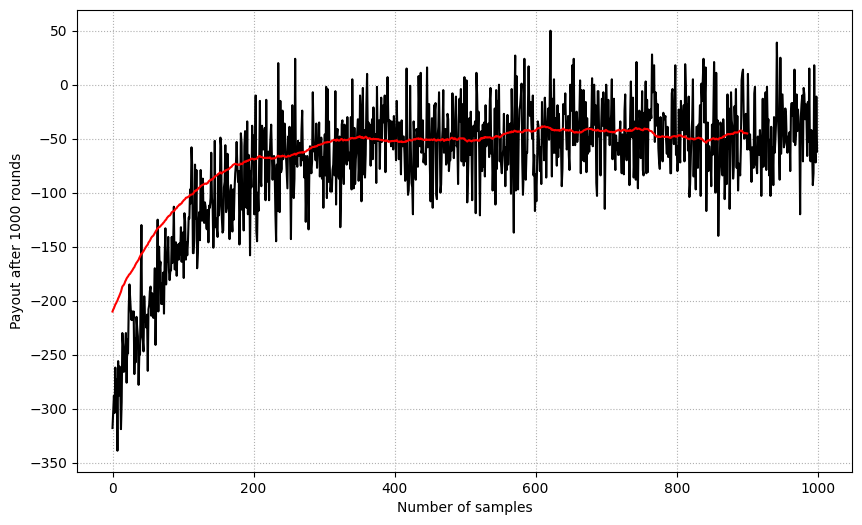

Average payout after 1000 rounds is: -72.14
Win rate: 42.5301 %


In [24]:
# Loading the custom model
env = BlackjackEnv()

agent = QLearningAgent(env=env, epsilon=.9, alpha=0.01, gamma=0.01, num_episodes=30000)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []
win = []
win_plot = []
c_round = 0

observation = env.reset()
lista = []

for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
        action = agent.choose_action(tuple(observation))
        next_observation, payout, is_done, _ = env.step(action)
        if action == 1:
            lista.append("stick")
        else:
            lista.append("hit")
        
        agent.learn(tuple(observation), action, payout, tuple(next_observation))
        total_payout += payout
        observation = next_observation
        '''
        img = env.render()
        
        if img is not None:
            img = img.astype(float)
            plt.imshow(img)
            plt.show()
        '''
        if payout == 1:
            win.append(payout)
        
        if is_done:
            observation = env.reset() # Environment deals new cards to player and dealer
            lista = []
            c_round += 1
            win_plot.append(win.count(1)/c_round)
            round += 1
    agent.train()
    average_payouts.append(total_payout)
    move_avg = agent.moving_average(average_payouts)
    


avg_run = average_payouts
avg_win = (win.count(1)/(num_rounds*num_samples))*100

# Plot payout per 1000 episodes for episode
plt.figure(figsize=(10,6))
plt.plot(avg_run, 'k-')
plt.plot(move_avg, 'r-')
plt.xlabel('Number of samples')
plt.ylabel('Payout after {} rounds'.format(num_rounds))
plt.grid(linestyle=':')
plt.show()      
    
print ("Average payout after {} rounds is: {}".format(num_rounds, sum(average_payouts)/(num_samples)))

print("Win rate: " + str(avg_win) + " %" )